<h2>REQUIREMENTS: "update_giovanni" branch of EPIX; "sim_sr0_v4" branch of CUTAX</h2>

In [1]:
#del sys.path[...]
#sys.path.insert(0,'.../epix') # 'fastsim_upd' branch

In [2]:
import warnings
warnings.filterwarnings("ignore", message="You are setting a default value")

import time
import sys

import numba
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from collections import Counter
import matplotlib.ticker as ticker

import cutax
print(f"cutax : {cutax.__version__}")

import epix
print(f"epix : {epix.__version__}")

import straxen
straxen.print_versions()

from epix.simulator.fast_simulator import StraxSimulator

2023-02-20 03:43:14,597 - admix - WARNING - Initializing utilix DB failed. You cannot do database operations


DB initialization failed


Could not import editors, GUI not available.


cutax : 1.14.1


*** Detector definition message ***
You are currently using the default XENON10 template detector.



Using nestpy version 2.0.0
epix : 0.4.0


<h2>Convenience functions</h2>

In [3]:
def ax_config(ax, title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, 
              grid_M_X = True, grid_M_Y = True, grid_m_X = True, grid_m_Y = True,
              colorbar = False, clabel='', sci = False, yscale = None, xscale = None, fontsize=20):
    Label_fontname = 'serif'
    if title != None: ax.set_title(title, fontname=Label_fontname)
    if xbounds != None: ax.set_xlim(xbounds[0], xbounds[1])
    if ybounds != None: ax.set_ylim(ybounds[0], ybounds[1])
    if xlabel != None: ax.set_xlabel(xlabel, fontname=Label_fontname)
    if ylabel != None: ax.set_ylabel(ylabel, fontname=Label_fontname)
    if xscale != None: ax.set_xscale(xscale)
    if yscale != None: ax.set_yscale(yscale)
        
    if isinstance(sci, str):
        plt.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
        
    if xscale == 'log':
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    else:
        ax.xaxis.set_minor_locator(AutoMinorLocator(10))
        
    if yscale == 'log':
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    else:
        ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
    if grid_M_X:
        ax.xaxis.grid(grid_M_X, which='major', color='black', alpha=0.1)
    if grid_M_Y:
        ax.yaxis.grid(grid_M_Y, which='major', color='black', alpha=0.1)
    if grid_m_X:
        ax.xaxis.grid(grid_m_X, which='minor', color='gray', alpha=0.1)
    if grid_m_Y:
        ax.yaxis.grid(grid_m_Y, which='minor', color='gray', alpha=0.1)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
        
    if isinstance(colorbar,str):
        plt.colorbar().set_label(label = colorbar,size=12, weight = None)
    elif colorbar:
        plt.colorbar(label = clabel)
    else:
        pass
    
    ax.set_facecolor('white')

<h2>Path</h2>

In [4]:
data_dir = '/dali/lgrandi/pkavrigin/2023-02-20_test_fastsim/'

#### AmBe source, Top U-Tube CW-5.9m
#g4_filename = 'ambe_tutcw5d9m_5E2events.root'
#g4_filename = 'ambe_tutcw5d9m_5E3events.root'
g4_filename = 'ambe_tutcw5d9m_5E4events.root'

s2_clustering_algorithm = 'bdt' # [ bdt | naive | nsort ]
# bdt - S2 clustering is defined by a BDT (Jaron Grigat)
# naive - S2 clustering is set via single separation distance value, currently hardcoded to 0.01 cm
# nsort - S2 clustering based on S2 area and separation distance, copied from nSort 

# File with BDT for S2 separation (by Jaron Grigat)
s2_separation_bdt_file = data_dir + 's2_separation_decision_tree_fast_sim.p'

# Your local directory for strax output
strax_data_dir = data_dir + 'strax'

In [5]:
# Clear old strax output
# %rm -r /dali/lgrandi/pkavrigin/2023-02-20_test_fastsim/strax/*

<h2>Parameters</h2>

In [6]:
st = cutax.contexts.xenonnt_sim_chain_SR0v4_cmt_v9(output_folder=strax_data_dir,)

run_id = 'fastsim0'

# epix config
epix_args={'path':data_dir,
           'file_name':g4_filename, 
           'detector_config_override':'/home/pkavrigin/sr0_epix_detectorconfig.ini',
           'debug':True,           
           'entry_start':0,
           'entry_stop':None,
           'cut_by_eventid':False,
           'micro_separation_time':10.0,
           'micro_separation':0.005,
           'tag_cluster_by':'energy',
           'max_delay':1e7,
           'source_rate':-1,
           'nr_only': True,
           'save_epix': False,}

configuration_files={'nv_pmt_qe':'nveto_pmt_qe.json',
                     'photon_area_distribution':'XENONnT_spe_distributions_20210305.csv',
                     's1_pattern_map': 'XENONnT_s1_xyz_patterns_LCE_corrected_qes_MCva43fa9b_wires.pkl',
                     's2_pattern_map': 'XENONnT_s2_xy_patterns_GXe_LCE_corrected_qes_MCv4.3.0_wires.pkl',
                     's1_lce_correction_map': False,
                     's2_correction_map': False,
                     's2_separation_bdt': s2_separation_bdt_file,
                    }

# for sim_context_v2/v3
fdc_fname = "XnT_3D_FDC_xyz_24_Jun_2022_MC.json.gz"
fdc_ext = fdc_fname.split(fdc_fname.split('.')[0] + ".")[-1]
_fax_config_override = {'detector':'XENONnT',
                        'se_gain_from_map': False,
                        'fdc_map': f"itp_map://resource://{fdc_fname}?fmt={fdc_ext}",
                       }

# Set up configuration
st.config.update(dict(fax_config='fax_config_nt_sr0_v2.json',                      
                      g4_file=data_dir+g4_filename,
                      epix_config=epix_args,
                      detector_config_override=epix_detector_config,
                      configuration_files=configuration_files,
                      s2_clustering_algorithm=s2_clustering_algorithm,
                      fax_config_overrides=_fax_config_override,
                     ))

st.register(StraxSimulator)

epix.simulator.fast_simulator.StraxSimulator

<h2>Run simulation</h2>

In [7]:
start_time = time.time()

st.make(run_id,'events_tpc')
st.make(run_id, 'events_nveto')

t = time.time()
print(f'It took {(t - start_time):.1f} [s] to finish the simulation.')

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/wfsim/load_resource.py:262: RuntimeWarning: invalid value encountered in divide
  orig_aft_=np.mean((s2map_topeff_/s2map_toteff_)[s2map_toteff_>0.0])
/home/pkavrigin/g4-analysis/notebooks/mc/epix/simulator/fast_simulator.py:249: UserWarning: The epix_config is subtle!detector_config_override is given by epix_config, while detector is from config I do not like it!
  warnings.warn('The epix_config is subtle!'


epix configuration:  {'path': '/dali/lgrandi/pkavrigin/2023-02-20_test_fastsim/', 'file_name': 'ambe_tutcw5d9m_5E4events.root', 'detector_config_override': '/home/pkavrigin/sr0_epix_detectorconfig.ini', 'debug': True, 'entry_start': 0, 'entry_stop': None, 'cut_by_eventid': False, 'micro_separation_time': 10.0, 'micro_separation': 0.005, 'tag_cluster_by': 'energy', 'max_delay': 10000000.0, 'source_rate': -1, 'nr_only': True, 'save_epix': False, 'detector_config': [<epix.detector_volumes.SensitiveVolume object at 0x7ff4e33cc250>, <epix.detector_volumes.SensitiveVolume object at 0x7ff4e33f7ac0>], 'outer_cylinder': {'max_z': 7.3936, 'min_z': -154.6555, 'max_r': 66.4}}
Total entries in input file = 14668
Starting to read from output file entry 0
It took 106.7372 sec to load data.
Finding clusters of interactions with a dr = 0.005 mm and dt = 10.0 ns
It took 5.1929 sec to find clusters.
It took 2.2834 sec to merge clusters.
Removing clusters not in volumes: TPC BelowCathode
Number of cluster

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: divide by zero encountered in func (vectorized)
  outputs = ufunc(*inputs)
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



 macro_cluster_events --> s2_clustering_algorithm == bdt . . .
Source finished!
It took 147.8 [s] to finish the simulation.


<h2>events_tpc</h2>

In [8]:
_events_tpc = st.get_array(run_id, 'events_tpc')
df_events_tpc = pd.DataFrame(_events_tpc)
df_events_tpc

Loading events_tpc: |          | 0.00 % [00:00<?]

,time,endtime,s1_area,s2_area,cs1,cs2,alt_s1_area,alt_s2_area,alt_cs1,alt_cs2,...,alt_s2_y,alt_s2_z,drift_time,alt_s2_drift_time,e_dep,alt_e_dep,x_pri,y_pri,z_pri,g4id
0,0,1,3.285106,338.332899,4.301323,368.149526,0.0,207.545755,0.0,208.296669,...,-42.572701,-12.319202,239334.332501,182506.702564,5.109969,1.603160,1.026443,-96.185394,-10.162767,2
1,1000,1001,52.045036,1699.215109,67.182165,1878.296848,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,16403.046361,0.000000,27.293877,0.000000,0.878100,-96.361763,-10.192369,301
2,2000,2001,50.303864,1781.603652,63.918103,1816.383560,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,91729.623300,0.000000,31.218472,0.000000,0.863013,-96.197128,-10.287435,563
3,3000,3001,2.927377,121.526958,3.908450,140.524668,0.0,132.039788,0.0,159.202361,...,-52.449486,-22.828074,166305.768048,338193.681505,0.933629,0.809617,0.825793,-96.259666,-10.263276,611
4,4000,4001,1.363793,246.064308,1.847769,307.063936,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,137332.012035,0.000000,4.820426,0.000000,0.936769,-96.274704,-10.272935,989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,285000,285001,102.469463,2164.580734,120.852498,2528.112231,0.0,416.033534,0.0,542.958698,...,-60.212292,-51.107521,896886.415835,757148.460106,57.112511,9.385606,0.787494,-96.251183,-10.301283,48467
281,286000,286001,11.673921,462.872780,15.876540,614.183815,0.0,220.529283,0.0,274.367665,...,-58.967487,-7.591212,217985.746596,112462.396975,8.384599,3.542579,0.916368,-96.431381,-10.180030,48744
282,287000,287001,8.437921,327.479256,11.389970,382.373512,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,317767.249213,0.000000,9.430532,0.000000,0.767253,-96.365631,-10.190062,48995
283,288000,288001,66.826469,3254.152732,90.887022,3651.075530,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,132096.071596,0.000000,52.951176,0.000000,1.033004,-96.325546,-10.098908,49730


/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]

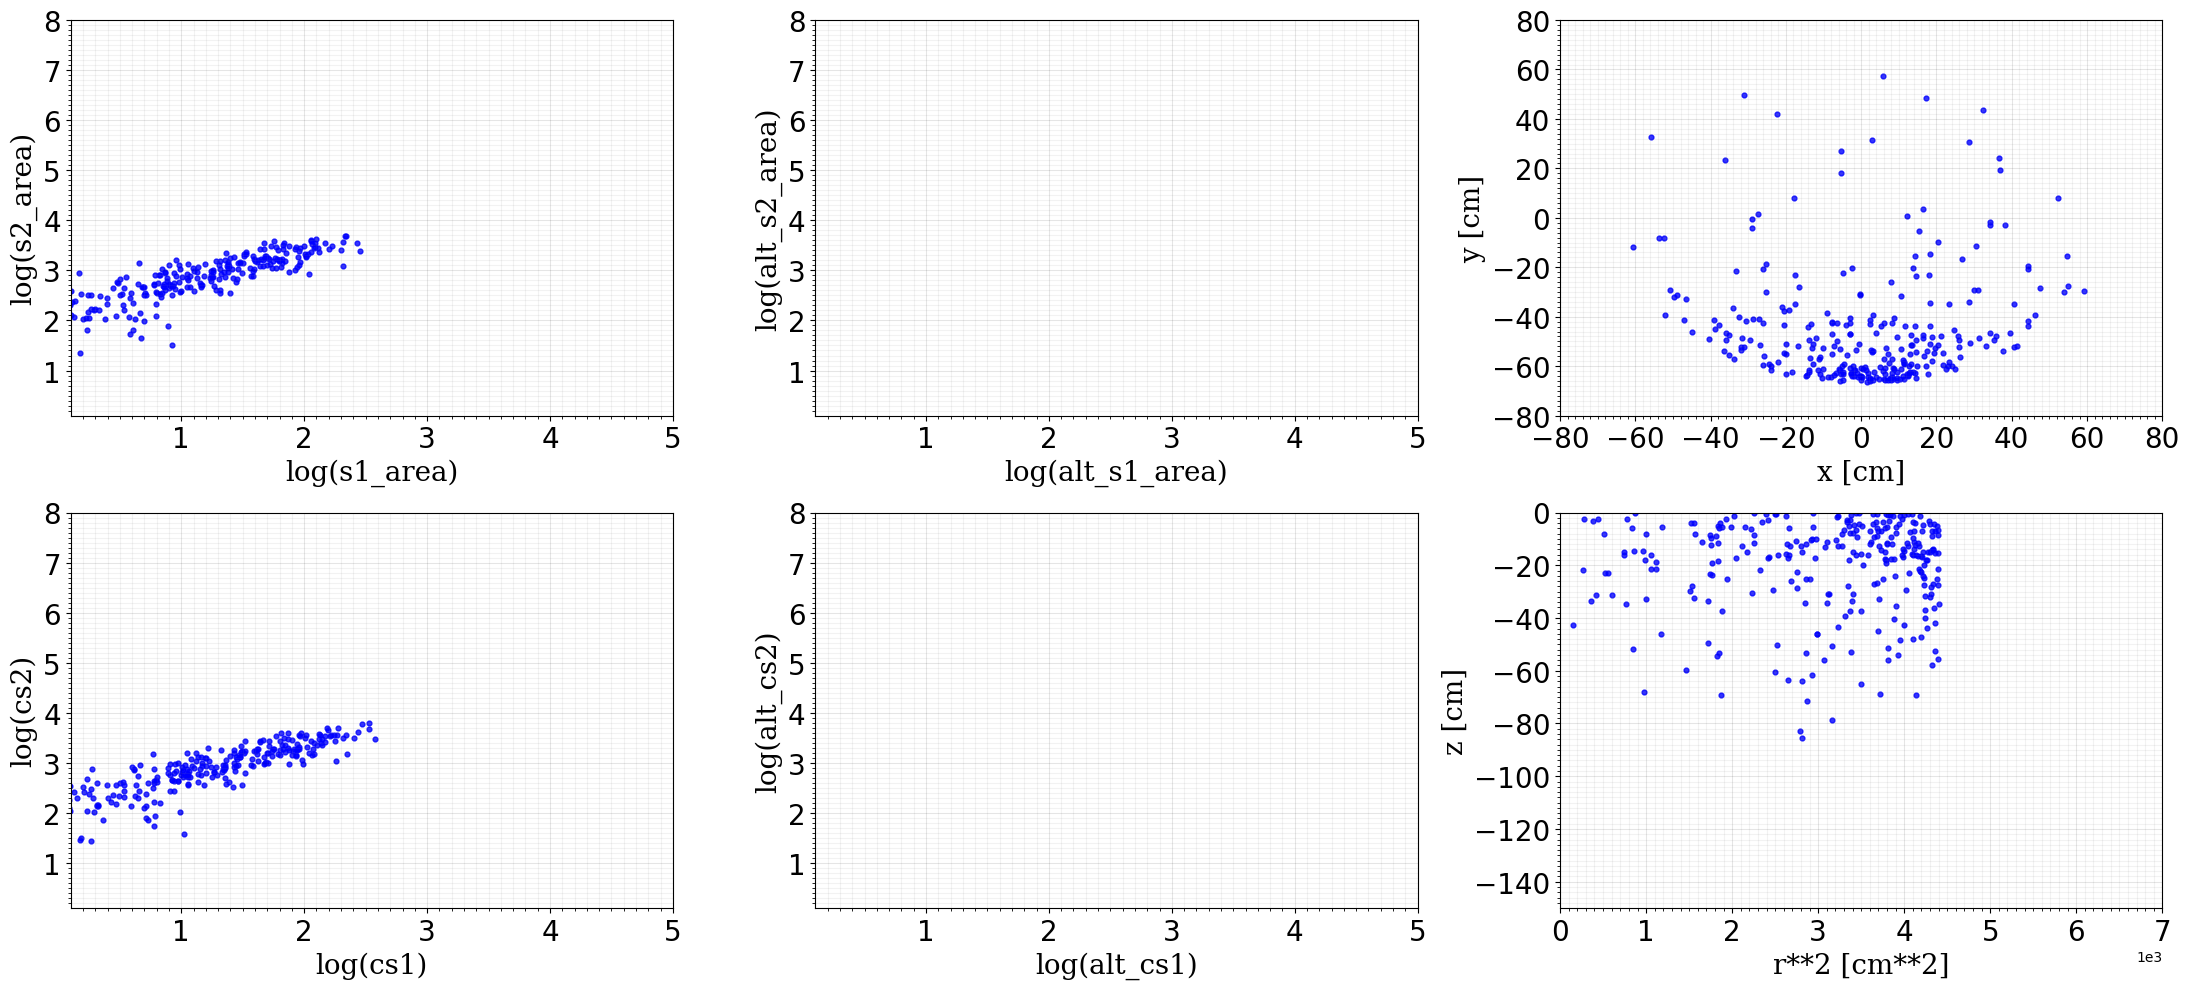

In [9]:
fig, ax = plt.subplots(2, 3, figsize=[22,10])

rr=[ [(0.1, 5.0), (0.1, 8.0)],
     [(0.1, 5.0), (0.1, 8.0)],    
     [(-80, 80), (-80, 80)],
     [(0.1, 5.0), (0.1, 8.0)],
     [(0.1, 5.0), (0.1, 8.0)],
     [(0.0, 7e3), (-150.0, 0.0)] ]

label_list = [ ['log(s1_area)', 'log(s2_area)'],
               ['log(alt_s1_area)', 'log(alt_s2_area)'],
               ['x [cm]','y [cm]'],
               ['log(cs1)', 'log(cs2)'],
               ['log(alt_cs1)', 'log(alt_cs2)'],
               ['r**2 [cm**2]', 'z [cm]'] ]

_ei = df_events_tpc

arr_list = [ [np.log10(_ei.s1_area), np.log10(_ei.s2_area)],
             [np.log10(_ei.alt_s1_area), np.log10(_ei.alt_s2_area)],
             [_ei.x, _ei.y],
             [np.log10(_ei.cs1), np.log10(_ei.cs2)],
             [np.log10(_ei.alt_cs1), np.log10(_ei.alt_cs2)], 
             [(_ei.x**2+_ei.y**2), _ei.z] ]

for ind, arr in enumerate(arr_list):
    _ax = ax[ind//3][ind%3]

    _ax.scatter(arr[0], 
                arr[1],
                color = 'blue',
                s=12,
                alpha=0.8)  

    ax_config(_ax, 
              xbounds = rr[ind][0],
              ybounds = rr[ind][1],
              xlabel=label_list[ind][0], 
              ylabel=label_list[ind][1])
    
    _ax.ticklabel_format(axis='x', style='sci', scilimits=(0,3))
    _ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3))

plt.tight_layout()
plt.plot()

<h2>events_nveto</h2>

In [10]:
df_events_nv = st.get_df(run_id, 'events_nveto')
df_events_nv

Loading events_nveto: |          | 0.00 % [00:00<?]

,time,endtime,event_id,channel
